# Finding Trends in NYC High School Performance Data

We've just received several spreadsheets of information on New York City High Schools. We want to look through this data and see what conclusions we can draw about *the performance of the 9-12 grades in these schools* so far. 

## 1 . Setup & read .csv files

Before we analyze our data, we need to take care of some basics. We'll import some helpful libraries, like pandas, to load our .csvs into easily usable dataframes. 

In [31]:
#import pandas, numpy, matplotlib, regex
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

#load matplotlib inline so we can plot
%matplotlib inline

# create list of csv files
data_files = ["ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"]
# create an empty dictionary to start
data = {}
# loop through list of .csv files and format into dataframe, then add to 'data' dictionary
for file in data_files:
    filename = file.replace('.csv', '')
    filepath = 'Data/schools/{0}'.format(file)
    data[filename] = pd.read_csv(filepath)
    
# print first 5 results from one of the dataframes
print(data['hs_directory'].head())


      dbn                                        school_name       boro  \
0  17K548                Brooklyn School for Music & Theatre   Brooklyn   
1  09X543                   High School for Violin and Dance      Bronx   
2  09X327        Comprehensive Model School Project M.S. 327      Bronx   
3  02M280     Manhattan Early College School for Advertising  Manhattan   
4  28Q680  Queens Gateway to Health Sciences Secondary Sc...     Queens   

  building_code    phone_number    fax_number grade_span_min  grade_span_max  \
0          K440    718-230-6250  718-230-6262              9              12   
1          X400    718-842-0687  718-589-9849              9              12   
2          X240    718-294-8111  718-294-8109              6              12   
3          M520  718-935-3477             NaN              9              10   
4          Q695    718-969-3155  718-969-3552              6              12   

  expgrade_span_min  expgrade_span_max  ...  \
0               NaN  

## 2. Add Survey .txt files

Everything is working so far. However, we still need to handle a couple files representing school survey answers. These are formatted slightly differently than the other files, so we will read them into datatables with a slightly different method. Then we will remove all but the columns we want to analyze.

In [32]:
# read survey .txt files, then combine into a single 'survey' dataframe
all_survey = pd.read_csv("Data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("Data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)
# capitalize 'DBN' column to keep consistent with rest of data
survey["DBN"] = survey["dbn"]

# create a list of the columns we want to analyze
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# filter out columns that aren't in our list 
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## 3. Normalize Class Size data

We also have class size data in different formats. We will write and run a quick function to make them all appear the same: '05' instead of just '5', for example.

In [33]:
# make capitalize 'DBN' column to keep consistent with rest of data
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# create a function normalize class size data so that its always 2 digits
# by adding a 0 in front of single digit class sizes
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# apply function to unformatted CSD data
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# combine class size data 
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## 4. Convert Columns to Numeric Values

Our tables contain sat_score data and latitude and longitude values that can be converted to more appropriate data types.

First we'll handle the sat_results and create a sat_score column from the total scores.

Then we'll create a couple functions to quickly format lat and long coordinates correctly so that we can convert them to numeric values as well. 

In [34]:
# make a list of columns to convert to numeric data types
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
# add the math, reading, and writing scores together to get total sat_score
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# functions to format latitude and longitude data correctly
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# format location data using our functions above, make numeric
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## 5. Condense Datasets

We still have a lot of information we don't need. We are only interested in the general education programs for grades 9-12. Furthermore, we want to focus on the 2011-2012 school year.

In [35]:
class_size = data["class_size"]
# only keep grades 9-12
class_size = class_size[class_size["GRADE "] == "09-12"]
# only keep info for gen ed program types
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# only look at the 2011-2012 school year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## 7. Convert AP scores to numeric values

In [36]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## 8. Combine the Datasets

In [37]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## 9. Add a School District Column for Mapping

In [38]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## 10. Find Correlations

In [39]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


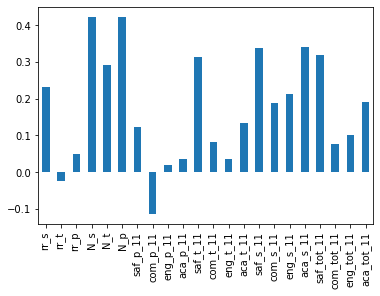

In [40]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

## 11. Survey Results

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

Surprisingly, there is a slight negative correlation between how parents score communication. Perhaps if parents get their way TOO much, students suffer? 

## 12. Exploring Safety on SAT Scores

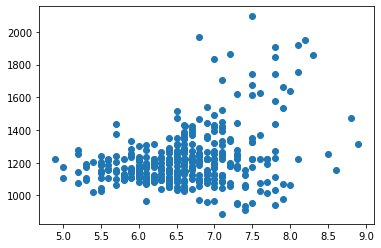

In [46]:
plt.scatter(x=combined['saf_s_11'],y=combined['sat_score'])

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. The correlation is stronger at the low end. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

## 13. Mapping Safe Areas

We'll look at the average safety score for each distract and map them so we can see the safest areas.

In [47]:
#Compute the Average Safety Score for Each District
## groupby school district and find means for columns
district_averages = combined.groupby('school_dist').agg(np.mean)
## reset index
district_averages.reset_index(inplace=True)
print(district_averages['saf_s_11'].head())

0    6.768611
1    6.910660
2    6.716667
3    6.885714
4    6.314286
Name: saf_s_11, dtype: float64


/Users/jessicadivers/anaconda3/envs/DataViz/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
/Users/jessicadivers/anaconda3/envs/DataViz/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


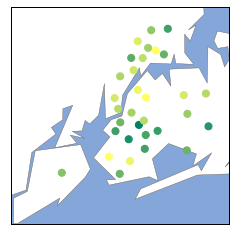

In [54]:
# optional: set location of project espg file to prevent errors
import os  
os.environ['PROJ_LIB'] = '/Users/jessicadivers/anaconda3/envs/DataViz/share/proj/'

#import Basemap for mapping
from mpl_toolkits.basemap import Basemap

#draw a map of new york using Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

#get coordinates from district averages data
longitudes = district_averages['lon'].tolist()
latitudes = district_averages['lat'].tolist()
#plot those coordinates on the map
m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True, c=district_averages['saf_s_11'], cmap='summer')
plt.show()

### Conclusions:


It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.


## 14. Finding Trends in Demographics and SAT Scores

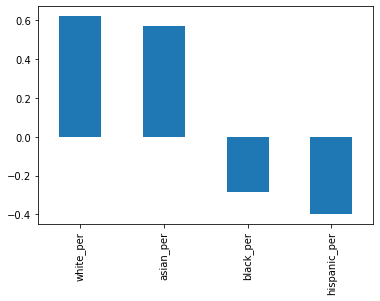

In [55]:
demographics = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
demographics_corr = combined.corr()['sat_score'][demographics].plot.bar()


When we check correlations with school demographics we see white and asian students correlated with better test scores than black and hispanic students.  This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

Let's dive further into the hispanic numbers since that demographic had the highest negative correlation.

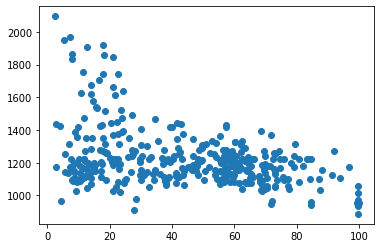

In [56]:
plt.scatter(x=combined['hispanic_per'],y=combined['sat_score'])

It seems like once schools exceed 25% of the population being hispanic, the sat scores drop to < 1400.

In [57]:
hispanic_95 = combined[combined['hispanic_per'] >= 95]
hispanic_95[['SCHOOL NAME','hispanic_per', 'sat_score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
'SAT Writing Avg. Score']].head(25)

,SCHOOL NAME,hispanic_per,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0,336.0,378.0,344.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0,380.0,395.0,399.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0,339.0,349.0,326.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0,315.0,339.0,297.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0,300.0,333.0,301.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0,321.0,351.0,298.0
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0,279.0,322.0,286.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0,317.0,323.0,311.0


From a quick google search it seems that most of these schools are catering to immigrant families that have recently arrived in the U.S. This explains why reading and writing scores may be lower for these students.

Lets look at opposite scenarios. We'll look for high scoring schools with less than 10% hispanic students.

In [58]:
hispanic_10 = combined[(combined['sat_score'] >= 1800) & (combined['hispanic_per'] <= 10)]
hispanic_10[['SCHOOL NAME','hispanic_per', 'sat_score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
'SAT Writing Avg. Score']].head(25)

,SCHOOL NAME,hispanic_per,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0,679.0,735.0,682.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0,632.0,688.0,649.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0,587.0,659.0,587.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0,612.0,660.0,596.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0,635.0,682.0,636.0


When we look up these schools online, we see that they are specialized schools serving already gifted students. Its not necessarily a surprise that students at these schools are scoring well.

Lets' move on and look at correlations with student gender.

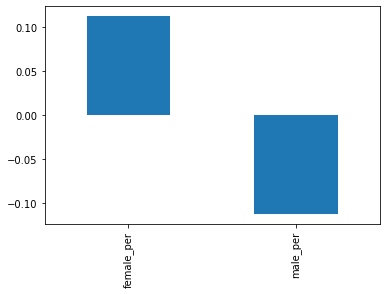

In [59]:
gender_pers = ['female_per', 'male_per']
gender_pers_corr = combined.corr()['sat_score'][gender_pers].plot.bar()


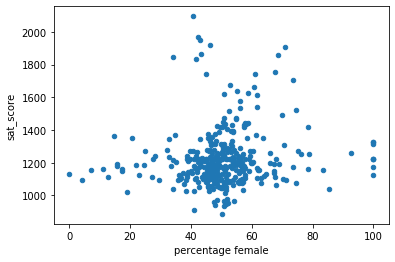

In [60]:
#usual way
#plt.scatter(x=combined['female_per'],y=combined['sat_score'])

#axis labels are acting buggy in jupyter notebooks
#heres a workaround with x axis labels
fig, ax = plt.subplots()
combined.plot(kind='scatter',x='female_per', y='sat_score', ax=ax)
ax.set_xlabel("percentage female")
plt.show()

In [61]:
female_60 = combined[(combined['female_per'] >= 60) & (combined['sat_score'] >= 1700)]
female_60[['SCHOOL NAME','female_per', 'sat_score', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
'SAT Writing Avg. Score']].head(25)

,SCHOOL NAME,female_per,sat_score,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0,624.0,604.0,628.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0,572.0,594.0,592.0
60,BEACON HIGH SCHOOL,61.0,1744.0,577.0,575.0,592.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0,566.0,564.0,577.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0,621.0,651.0,638.0


### Conclusions:
It seems like school test scores are only loosely correlated with gender, however, scores do the best when there is more of an even mix between genders than either extreme.

Looking closer at the highest scoring schools with the most women, we see that they are geberally selective liberal arts schools that have high academic standards.


## 15. AP Exam Scores vs SAT Scores


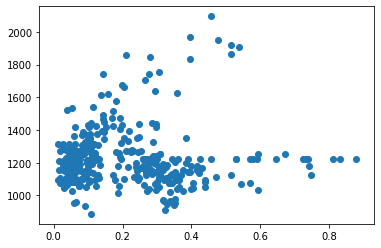

In [62]:
#calculate percentage of students taking AP exams
combined['AP_per'] = combined['AP Test Takers '] / combined['total_enrollment']
plt.scatter(x=combined['AP_per'],y=combined['sat_score'])

### Conclusions:

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.